In [1]:
import numpy as np
import pandas as pd
import re
import pickle
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_csv("C:/Users/andri/Documents/Andri Martin/Trisakti/Semester 6/DBS_Coding-Camp2025/Capstone/Colab/Capstone_Akmal_Andri_Zahran/recipes_new.csv")
data.head()

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,1440,45,1485,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,https://img.sndimg.com/food/image/upload/w_555...,...,2,1,8,30,37,4,30,3,4.0,"Toss 2 cups berries with sugar., Let stand for..."
1,45,Buttermilk Pie With Gingersnap Crumb Crust,1580,tristitia,50,30,80,1999-08-06T00:40:00Z,Make and share this Buttermilk Pie With Ginger...,https://img.sndimg.com/food/image/upload/w_555...,...,7,2,24,282,38,0,25,4,8.0,"Preheat oven to 350°F., Make pie crust, using ..."
2,49,Chicken Breasts Lombardi,174711,Queen Dragon Mom,30,45,75,1999-08-14T19:58:00Z,Make and share this Chicken Breasts Lombardi r...,https://img.sndimg.com/food/image/upload/w_555...,...,25,13,203,849,14,1,2,58,6.0,Cook mushrooms in 2 tbsp butter in a large sk...
3,56,Buttermilk Pie,1581,thefensk,60,20,80,1999-08-30T10:02:00Z,This recipe was originally noted by my wife on...,https://img.sndimg.com/food/image/upload/w_555...,...,19,10,102,270,52,1,40,5,8.0,"Preheat oven to 400°F., Beat the butter and su..."
4,58,Low-Fat Burgundy Beef & Vegetable Stew,1533,Dancer,134,30,164,1999-08-14T19:48:00Z,Make and share this Low-Fat Burgundy Beef & Ve...,https://img.sndimg.com/food/image/upload/w_555...,...,6,2,67,592,22,6,9,30,6.0,"Trim fat from beef, cut into 1-inch pieces., I..."


In [3]:
# Tampilkan semua kolom
pd.set_option('display.max_columns', None)  # Tidak ada batas jumlah kolom
pd.set_option('display.expand_frame_repr', False)  # Tampilkan dalam 1 baris (jika memungkinkan)
data = pd.read_csv("C:/Users/andri/Documents/Andri Martin/Trisakti/Semester 6/DBS_Coding-Camp2025/Capstone/Colab/Capstone_Akmal_Andri_Zahran/recipes_new.csv")
data.head()

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,1440,45,1485,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,https://img.sndimg.com/food/image/upload/w_555...,Frozen Desserts,"Dessert, Low Protein, Low Cholesterol, Healthy...","4, 1/4, 1, 1","blueberries, granulated sugar, vanilla yogurt,...",4.5,4.0,171,2,1,8,30,37,4,30,3,4.0,"Toss 2 cups berries with sugar., Let stand for..."
1,45,Buttermilk Pie With Gingersnap Crumb Crust,1580,tristitia,50,30,80,1999-08-06T00:40:00Z,Make and share this Buttermilk Pie With Ginger...,https://img.sndimg.com/food/image/upload/w_555...,Pie,"Dessert, Healthy, Weeknight, Oven, < 4 Hours","3/4, 1, 1, 2, 3, 1/4, 1, 1/2, 1/2, 2","sugar, margarine, egg, flour, salt, buttermilk...",4.0,3.0,228,7,2,24,282,38,0,25,4,8.0,"Preheat oven to 350°F., Make pie crust, using ..."
2,49,Chicken Breasts Lombardi,174711,Queen Dragon Mom,30,45,75,1999-08-14T19:58:00Z,Make and share this Chicken Breasts Lombardi r...,https://img.sndimg.com/food/image/upload/w_555...,Chicken Breast,"Chicken, Poultry, Meat, European, Very Low Car...","2, 2, 12, 1/2, 1/3, 3/4, 1/2, 1/2, 1/2, 1/2, 1/4","fresh mushrooms, butter, boneless skinless chi...",5.0,21.0,628,25,13,203,849,14,1,2,58,6.0,Cook mushrooms in 2 tbsp butter in a large sk...
3,56,Buttermilk Pie,1581,thefensk,60,20,80,1999-08-30T10:02:00Z,This recipe was originally noted by my wife on...,https://img.sndimg.com/food/image/upload/w_555...,Pie,"Dessert, Oven, < 4 Hours, Easy","1/2, 1 1/2, 3, 3, 1, 1, 1, 1","butter, margarine, sugar, flour, eggs, salt, v...",5.0,171.0,396,19,10,102,270,52,1,40,5,8.0,"Preheat oven to 400°F., Beat the butter and su..."
4,58,Low-Fat Burgundy Beef & Vegetable Stew,1533,Dancer,134,30,164,1999-08-14T19:48:00Z,Make and share this Low-Fat Burgundy Beef & Ve...,https://img.sndimg.com/food/image/upload/w_555...,Stew,"Vegetable, Meat, Low Cholesterol, Healthy, Fre...","1 1/2, 1, 1, 1/2, 1/2, 1, 1/2, 3, 5 1/2, 1, 2, 1","beef eye round, dried thyme leaves, salt, pepp...",4.5,7.0,280,6,2,67,592,22,6,9,30,6.0,"Trim fat from beef, cut into 1-inch pieces., I..."


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52785 entries, 0 to 52784
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   RecipeId                    52785 non-null  int64  
 1   Name                        52785 non-null  object 
 2   AuthorId                    52785 non-null  int64  
 3   AuthorName                  52785 non-null  object 
 4   CookTime                    52785 non-null  int64  
 5   PrepTime                    52785 non-null  int64  
 6   TotalTime                   52785 non-null  int64  
 7   DatePublished               52785 non-null  object 
 8   Description                 52785 non-null  object 
 9   Images                      52785 non-null  object 
 10  RecipeCategory              52785 non-null  object 
 11  Keywords                    52785 non-null  object 
 12  RecipeIngredientQuantities  52785 non-null  object 
 13  RecipeIngredientParts       527

In [5]:
columns = [
    'RecipeId', 'Name', 'CookTime', 'PrepTime', 'TotalTime',
    'RecipeIngredientParts', 'Calories', 'FatContent', 'SaturatedFatContent',
    'CholesterolContent', 'SodiumContent', 'CarbohydrateContent',
    'FiberContent', 'SugarContent', 'ProteinContent', 'RecipeServings', 'Keywords', 
    'Images'
]
data = data[columns]
data.head()

,RecipeId,Name,CookTime,PrepTime,TotalTime,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,Keywords,Images
0,38,Low-Fat Berry Blue Frozen Dessert,1440,45,1485,"blueberries, granulated sugar, vanilla yogurt,...",171,2,1,8,30,37,4,30,3,4.0,"Dessert, Low Protein, Low Cholesterol, Healthy...",https://img.sndimg.com/food/image/upload/w_555...
1,45,Buttermilk Pie With Gingersnap Crumb Crust,50,30,80,"sugar, margarine, egg, flour, salt, buttermilk...",228,7,2,24,282,38,0,25,4,8.0,"Dessert, Healthy, Weeknight, Oven, < 4 Hours",https://img.sndimg.com/food/image/upload/w_555...
2,49,Chicken Breasts Lombardi,30,45,75,"fresh mushrooms, butter, boneless skinless chi...",628,25,13,203,849,14,1,2,58,6.0,"Chicken, Poultry, Meat, European, Very Low Car...",https://img.sndimg.com/food/image/upload/w_555...
3,56,Buttermilk Pie,60,20,80,"butter, margarine, sugar, flour, eggs, salt, v...",396,19,10,102,270,52,1,40,5,8.0,"Dessert, Oven, < 4 Hours, Easy",https://img.sndimg.com/food/image/upload/w_555...
4,58,Low-Fat Burgundy Beef & Vegetable Stew,134,30,164,"beef eye round, dried thyme leaves, salt, pepp...",280,6,2,67,592,22,6,9,30,6.0,"Vegetable, Meat, Low Cholesterol, Healthy, Fre...",https://img.sndimg.com/food/image/upload/w_555...


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52785 entries, 0 to 52784
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RecipeId               52785 non-null  int64  
 1   Name                   52785 non-null  object 
 2   CookTime               52785 non-null  int64  
 3   PrepTime               52785 non-null  int64  
 4   TotalTime              52785 non-null  int64  
 5   RecipeIngredientParts  52785 non-null  object 
 6   Calories               52785 non-null  int64  
 7   FatContent             52785 non-null  int64  
 8   SaturatedFatContent    52785 non-null  int64  
 9   CholesterolContent     52785 non-null  int64  
 10  SodiumContent          52785 non-null  int64  
 11  CarbohydrateContent    52785 non-null  int64  
 12  FiberContent           52785 non-null  int64  
 13  SugarContent           52785 non-null  int64  
 14  ProteinContent         52785 non-null  int64  
 15  Re

In [7]:
# Preprocessing keywords
def preprocess_keywords(df):
    df['Keywords_list'] = df['Keywords'].str.lower().str.split(',\s*')
    return df

data = preprocess_keywords(data)

In [8]:
# Kategori keyword yang baru
GENERAL_DIET_AND_HEALTH_KEYWORDS = {
    'Dietary Restrictions': [
        'vegetarian', 'vegan', 'dairy free foods', 'egg free', 'lactose free',
        'no shell fish', 'free of...'
    ],
    'Health Focus': [
        'low calorie', 'healthy', 'light', 'low cholesterol', 'low protein',
        'very low carbs', 'high fiber', 'high protein', 'protein'
    ]
}

GENERAL_COOKING_AND_EQUIPMENT_KEYWORDS = {
    'Cooking Methods': [
        'no cook', 'stove top', 'oven', 'baking', 'broil/grill', 'microwave',
        'pressure cooker', 'deep fried', 'steam', 'stir fry', 'wok'
    ],
    'Equipment': [
        'small appliance', 'mixer', 'dehydrator', 'refrigerator', 'freezer',
        'bread machine'
    ]
}

GENERAL_MEAL_AND_TIME_KEYWORDS = {
    'Meal Type': [
        'breakfast', 'brunch', 'lunch/snacks', 'one dish meal', 'stew',
        'pot roast', 'meatloaf', 'dessert', 'frozen desserts', 'ice cream',
        'cheesecake', 'bar cookie', 'drop cookies', 'chocolate chip cookies',
        'cake', 'chowders', 'clear soup', 'beef barley soup', 'mushroom soup',
        'pasta shells', 'penne', 'spaghetti', 'macaroni and cheese', 'manicotti',
        'pasta elbow', 'breads', 'quick breads', 'yeast breads',
        'sourdough breads', 'savory pies', 'pie', 'cookie & brownie',
        'beverages', 'punch beverage', 'smoothies', 'shakes', 'sauces',
        'chutneys', 'spreads', 'side dish', 'accompaniment', 'garnish',
        'coleslaw', 'potato salad'
    ],
    'Time & Budget': [
        '< 15 mins', '< 30 mins', '< 60 mins', '< 4 hours', 'weeknight',
        'inexpensive'
    ]
}

GENERAL_INGREDIENT_KEYWORDS = {
    'Proteins & Produce': [
        'chicken', 'beef', 'pork', 'duck', 'goose', 'turkey', 'veal', 'rabbit',
        'lamb/sheep', 'quail', 'deer', 'moose', 'elk', 'pheasant', 'wild game',
        'fish', 'seafood', 'salmon', 'tuna', 'halibut', 'bass', 'catfish',
        'tilapia', 'trout', 'whitefish', 'mahi mahi', 'orange roughy', 'crab',
        'lobster', 'mussels', 'oysters', 'squid', 'octopus', 'crawfish',
        'vegetable', 'soy/tofu', 'tempeh', 'cauliflower', 'artichoke',
        'onions', 'collard greens', 'spinach', 'chard', 'peppers', 'pumpkin',
        'apple', 'strawberry', 'plums', 'pineapple', 'cherries', 'berries',
        'raspberries', 'kiwifruit', 'melons', 'oranges', 'papaya', 'mango',
        'coconut', 'pear', 'lime', 'grapes', 'citrus', 'avocado', 'tropical fruits'
    ],
    'Pantry Staples': [
        'rice', 'brown rice', 'white rice', 'short grain rice',
        'medium grain rice', 'long grain rice', 'oatmeal', 'corn', 'beans',
        'black beans', 'lentil', 'peanut butter', 'cheese', 'yogurt',
        'nuts'
    ]
}

GENERAL_CULTURE_AND_FLAVOR_KEYWORDS = {
    'Regional Cuisine': [
        'chinese', 'japanese', 'thai', 'vietnamese', 'indonesian', 'korean',
        'filipino', 'cambodian', 'malaysian', 'burmese', 'singaporean',
        'laotian', 'pakistani', 'indian', 'bangladeshi', 'nepali', 'sri lankan',
        'southwest asia (middle east)', 'lebanese', 'turkish', 'iraqi',
        'iranian', 'italian', 'greek', 'french', 'german', 'scandinavian',
        'norwegian', 'swedish', 'dutch', 'austrian', 'swiss', 'welsh',
        'finnish', 'polish', 'portuguese', 'russian', 'hungarian', 'czech',
        'georgian', 'spanish', 'moroccan', 'nigerian', 'egyptian',
        'ethiopian', 'south african', 'sudanese', 'somalian', 'ghanaian',
        'kenyan', 'tanzanian', 'southern u.s.', 'southwestern u.s.',
        'native american', 'puerto rican', 'cuban', 'caribbean', 'creole',
        'cajun', 'tex mex', 'brazilian', 'argentinian', 'chilean', 'peruvian',
        'colombian', 'ecuadorean', 'venezuelan', 'guatemalan', 'costarican',
        'mexican', 'honduran', 'nicaraguan', 'salvadoran', 'panamanian',
        'bolivian', 'paraguayan', 'uruguayan', 'australian', 'new zealand',
        'polynesian', 'fijian', 'samoan', 'canadian', 'icelandic'
    ],
    'Flavor & Occasion': [
        'spicy', 'hot chili', 'cayenne', 'peppery', 'fiery', 'umami', 'savory',
        'rich', 'meaty', 'miso', 'sweet', 'sugary', 'honeyed', 'sour', 'tangy',
        'citrusy', 'vinegary', 'bitter', 'salty', 'briny', 'soy sauce',
        'christmas', 'thanksgiving', 'halloween', "st. patrick's day",
        'ramadan', 'hanukkah', 'labor day', 'memorial day', 'birthday', 'easter',
        'new year', 'spring', 'summer', 'winter', 'fall', 'potluck',
        'for large groups', 'camping', 'college food', 'beginner cook'
    ]
}

In [9]:
# Gabungkan semua kategori
ALL_CATEGORIES = {}
for category_group in [
    GENERAL_DIET_AND_HEALTH_KEYWORDS,
    GENERAL_COOKING_AND_EQUIPMENT_KEYWORDS,
    GENERAL_MEAL_AND_TIME_KEYWORDS,
    GENERAL_INGREDIENT_KEYWORDS,
    GENERAL_CULTURE_AND_FLAVOR_KEYWORDS
]:
    ALL_CATEGORIES.update(category_group)

CATEGORY_NAMES = list(ALL_CATEGORIES.keys())


In [10]:
# Buat representasi vektor untuk setiap resep
def create_feature_vector(keywords_list):
    vector = [0] * len(CATEGORY_NAMES)
    if not isinstance(keywords_list, list):
        return vector
        
    for i, category in enumerate(CATEGORY_NAMES):
        category_keywords = ALL_CATEGORIES[category]
        for kw in category_keywords:
            if kw in keywords_list:
                vector[i] = 1
                break
    return vector

In [11]:
# Tambahkan vektor fitur ke dataset
print("Creating feature vectors...")
data['feature_vector'] = data['Keywords_list'].apply(create_feature_vector)


Creating feature vectors...


Deep Learning

In [12]:
# -------- Generate synthetic interactions -------- #
def generate_interactions(data, num_users=100, interaction_ratio=0.2):
    interactions = []
    recipe_ids = data['RecipeId'].unique()
    
    for user_id in range(1, num_users + 1):
        num_interactions = int(len(recipe_ids) * interaction_ratio)
        selected_recipes = np.random.choice(recipe_ids, size=num_interactions, replace=False)

        for recipe_id in selected_recipes:
            recipe_idx = data[data['RecipeId'] == recipe_id].index[0]
            features = data.loc[recipe_idx, 'feature_vector']

            user_pref = np.random.choice([0, 1], size=len(features), p=[0.7, 0.3])
            similarity = np.dot(features, user_pref) / (np.linalg.norm(features) * np.linalg.norm(user_pref) + 1e-9)
            rating = min(5, max(1, int(similarity * 3 + np.random.normal(3, 1))))
            interactions.append([user_id, recipe_id, rating])
    
    return pd.DataFrame(interactions, columns=['user_id', 'RecipeId', 'rating'])


In [13]:
# -------- Data Preparation -------- #
print("Generating synthetic data...")
# Asumsikan 'data' sudah tersedia dan memuat kolom: 'RecipeId', 'feature_vector', dan kolom nutrisi
interactions_df = generate_interactions(data, num_users=100)


Generating synthetic data...


In [14]:
# Mapping RecipeId to index
recipe_id_map = {id_: idx for idx, id_ in enumerate(data['RecipeId'].unique())}
data['recipe_idx'] = data['RecipeId'].map(recipe_id_map)

In [15]:
# Normalize nutritional features
nutritional_cols = ['Calories', 'FatContent', 'SaturatedFatContent', 
                   'CholesterolContent', 'SodiumContent', 'CarbohydrateContent',
                   'FiberContent', 'SugarContent', 'ProteinContent']

scaler = MinMaxScaler()
data[nutritional_cols] = scaler.fit_transform(data[nutritional_cols])

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52785 entries, 0 to 52784
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RecipeId               52785 non-null  int64  
 1   Name                   52785 non-null  object 
 2   CookTime               52785 non-null  int64  
 3   PrepTime               52785 non-null  int64  
 4   TotalTime              52785 non-null  int64  
 5   RecipeIngredientParts  52785 non-null  object 
 6   Calories               52785 non-null  float64
 7   FatContent             52785 non-null  float64
 8   SaturatedFatContent    52785 non-null  float64
 9   CholesterolContent     52785 non-null  float64
 10  SodiumContent          52785 non-null  float64
 11  CarbohydrateContent    52785 non-null  float64
 12  FiberContent           52785 non-null  float64
 13  SugarContent           52785 non-null  float64
 14  ProteinContent         52785 non-null  float64
 15  Re

In [17]:
data.head()

,RecipeId,Name,CookTime,PrepTime,TotalTime,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,Keywords,Images,Keywords_list,feature_vector,recipe_idx
0,38,Low-Fat Berry Blue Frozen Dessert,1440,45,1485,"blueberries, granulated sugar, vanilla yogurt,...",0.131433,0.025974,0.030303,0.021563,0.012063,0.274074,0.333333,0.638298,0.031915,4.0,"Dessert, Low Protein, Low Cholesterol, Healthy...",https://img.sndimg.com/food/image/upload/w_555...,"[dessert, low protein, low cholesterol, health...","[1, 1, 0, 1, 1, 1, 0, 0, 0, 1]",0
1,45,Buttermilk Pie With Gingersnap Crumb Crust,50,30,80,"sugar, margarine, egg, flour, salt, buttermilk...",0.176564,0.090909,0.060606,0.064690,0.116889,0.281481,0.000000,0.531915,0.042553,8.0,"Dessert, Healthy, Weeknight, Oven, < 4 Hours",https://img.sndimg.com/food/image/upload/w_555...,"[dessert, healthy, weeknight, oven, < 4 hours]","[0, 1, 1, 0, 1, 1, 0, 0, 0, 0]",1
2,49,Chicken Breasts Lombardi,30,45,75,"fresh mushrooms, butter, boneless skinless chi...",0.493270,0.324675,0.393939,0.547170,0.352745,0.103704,0.083333,0.042553,0.617021,6.0,"Chicken, Poultry, Meat, European, Very Low Car...",https://img.sndimg.com/food/image/upload/w_555...,"[chicken, poultry, meat, european, very low ca...","[0, 1, 1, 0, 0, 1, 1, 0, 0, 0]",2
3,56,Buttermilk Pie,60,20,80,"butter, margarine, sugar, flour, eggs, salt, v...",0.309580,0.246753,0.303030,0.274933,0.111897,0.385185,0.083333,0.851064,0.053191,8.0,"Dessert, Oven, < 4 Hours, Easy",https://img.sndimg.com/food/image/upload/w_555...,"[dessert, oven, < 4 hours, easy]","[0, 0, 1, 0, 1, 1, 0, 0, 0, 0]",3
4,58,Low-Fat Burgundy Beef & Vegetable Stew,134,30,164,"beef eye round, dried thyme leaves, salt, pepp...",0.217736,0.077922,0.060606,0.180593,0.245840,0.162963,0.500000,0.191489,0.319149,6.0,"Vegetable, Meat, Low Cholesterol, Healthy, Fre...",https://img.sndimg.com/food/image/upload/w_555...,"[vegetable, meat, low cholesterol, healthy, fr...","[1, 1, 0, 0, 0, 1, 1, 0, 0, 0]",4


In [18]:
# -------- Build combined feature dictionary -------- #
print("Precomputing recipe features...")
recipe_features = np.array(data['feature_vector'].tolist())
recipe_feature_dict = {}

for recipe_id in data['RecipeId'].unique():
    idx = recipe_id_map[recipe_id]
    nutritional_features = data.loc[data['RecipeId'] == recipe_id, nutritional_cols].values[0]
    category_features = recipe_features[idx]
    combined = np.concatenate([nutritional_features, category_features])
    recipe_feature_dict[recipe_id] = combined


Precomputing recipe features...


In [19]:
# -------- Build dataset -------- #
print("Building interaction dataset...")
X = []
y = []

# Map user_id to index starting from 0
user_id_map = {uid: idx for idx, uid in enumerate(interactions_df['user_id'].unique())}
interactions_df['user_idx'] = interactions_df['user_id'].map(user_id_map)
interactions_df['recipe_idx'] = interactions_df['RecipeId'].map(recipe_id_map)

for row in interactions_df.itertuples(index=False):
    user_idx = row.user_idx
    recipe_idx = row.recipe_idx
    rating = row.rating
    recipe_id = row.RecipeId

    features = recipe_feature_dict.get(recipe_id)
    if features is not None:
        X.append([user_idx, recipe_idx, *features])
        y.append(rating)

X = np.array(X)
y = np.array(y)

Building interaction dataset...


In [20]:
# -------- Split dataset -------- #
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_user_ids = X_train[:, 0]
train_recipe_ids = X_train[:, 1]
train_features = X_train[:, 2:]

test_user_ids = X_test[:, 0]
test_recipe_ids = X_test[:, 1]
test_features = X_test[:, 2:]

In [21]:
# -------- Build Model -------- #
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

def build_ncf_model(num_users, num_recipes, feature_dim):
    user_input = Input(shape=(1,))
    recipe_input = Input(shape=(1,))
    feature_input = Input(shape=(feature_dim,))

    user_embedding = Embedding(input_dim=num_users, output_dim=64)(user_input)
    recipe_embedding = Embedding(input_dim=num_recipes, output_dim=64)(recipe_input)

    user_vec = Flatten()(user_embedding)
    recipe_vec = Flatten()(recipe_embedding)

    concat = Concatenate()([user_vec, recipe_vec, feature_input])

    dense = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-3))(concat)
    dense = Dropout(0.5)(dense)

    dense = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-3))(dense)
    dense = Dropout(0.5)(dense)

    dense = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-3))(dense)

    output = Dense(1, activation='linear')(dense)

    model = Model(inputs=[user_input, recipe_input, feature_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

    return model

In [22]:
# -------- Train model -------- #
from tensorflow.keras.callbacks import EarlyStopping

print("Training model...")
num_users = len(user_id_map)
num_recipes = len(recipe_id_map)
feature_dim = train_features.shape[1]

model = build_ncf_model(num_users, num_recipes, feature_dim)
model.summary()

Training model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 64)                6400      ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 64)                3378240   ['input_2[0][0]']             
                                                                            

In [23]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    [train_user_ids, train_recipe_ids, train_features],
    y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping]
)

Epoch 1/50
11877/11877 [==============================] - 502s 42ms/step - loss: 1.4582 - mae: 0.9750 - val_loss: 1.3418 - val_mae: 0.9684
Epoch 2/50
11877/11877 [==============================] - 584s 49ms/step - loss: 1.3383 - mae: 0.9605 - val_loss: 1.3368 - val_mae: 0.9622
Epoch 3/50
11877/11877 [==============================] - 602s 51ms/step - loss: 1.3141 - mae: 0.9462 - val_loss: 1.3454 - val_mae: 0.9643
Epoch 4/50
 4049/11877 [=========>....................] - ETA: 6:06 - loss: 1.2910 - mae: 0.9326

KeyboardInterrupt: 

In [ ]:
# -------- Evaluate and Save -------- #
print("Evaluating model...")
test_loss, test_mae = model.evaluate([test_user_ids, test_recipe_ids, test_features], y_test)
print(f"\nTest MAE: {test_mae:.3f}, Test Loss: {test_loss:.3f}")

Evaluating model...
6599/6599 [==============================] - 8s 1ms/step - loss: 1.3453 - mae: 0.9672

Test MAE: 0.967, Test Loss: 1.345


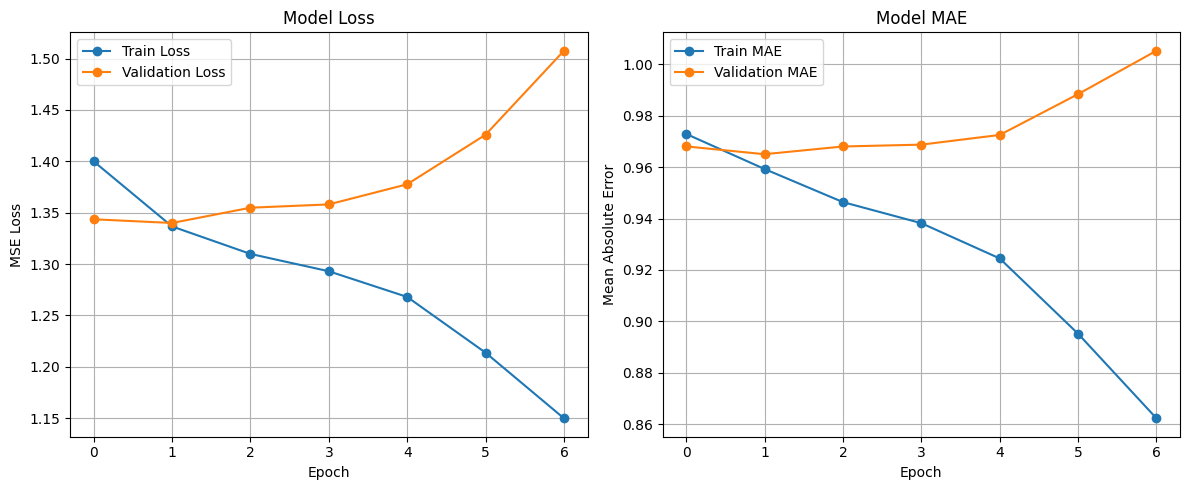

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', marker='o')
plt.plot(history.history['val_mae'], label='Validation MAE', marker='o')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Save model
model.save('food_recommender_ncf.h5')
print("Model saved to 'food_recommender_ncf.h5'")


Model saved to 'food_recommender_ncf.h5'


c:\Users\andri\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


HYBRID RECOMMENDATION FUNCTION

In [ ]:
# ===== TAMBAHKAN KODE BARU DI SINI =====
def get_combined_features(recipe_id):
    """Mengambil fitur gabungan nutrisi+kategori untuk resep tertentu"""
    recipe = data[data['RecipeId'] == recipe_id]
    if recipe.empty:
        return None
    
    # Gabungkan fitur nutrisi dan kategori
    nutritional = recipe[nutritional_cols].values[0]
    categories = recipe['feature_vector'].values[0]
    return np.concatenate([nutritional, categories])

def map_preferences(preferences):
    """Mengubah preferensi teks menjadi vektor fitur"""
    # Inisialisasi vektor preferensi (61 kategori)
    pref_vector = [0] * len(CATEGORY_NAMES)
    
    # Mapping preferensi umum ke kategori
    preference_mapping = {
        'high protein': 'Health Focus',
        'low calorie': 'Health Focus',
        'quick': 'Time & Budget',
        'vegetarian': 'Dietary Restrictions',
        'asian': 'Regional Cuisine',
        'spicy': 'Flavor & Occasion'
    }
    
    for pref in preferences:
        pref_lower = pref.lower()
        
        # Cek mapping khusus
        for key, category in preference_mapping.items():
            if key in pref_lower:
                try:
                    idx = CATEGORY_NAMES.index(category)
                    pref_vector[idx] = 1
                except ValueError:
                    pass
                
        # Cek langsung di kategori
        for i, category in enumerate(CATEGORY_NAMES):
            if pref_lower in category.lower():
                pref_vector[i] = 1
                
    return pref_vector

def recommend_foods(target_calories, preferences, is_vegetarian, top_n):
    """Content-based filtering awal"""
    # 1. Filter dasar
    low_bound = target_calories * 0.7
    high_bound = target_calories * 1.3
    filtered = data[
        (data['Calories'] >= low_bound) & 
        (data['Calories'] <= high_bound)
    ]
    
    # Debug: print jumlah resep setelah filter kalori
    print(f"Found {len(filtered)} recipes after calorie filtering")
    
    # 2. Filter vegetarian jika diperlukan
    if is_vegetarian:
        filtered = filtered[
            filtered['Keywords_list'].apply(
                lambda x: 'vegetarian' in x or 'vegan' in x if isinstance(x, list) else False
            )
        ]
        print(f"After vegetarian filter: {len(filtered)} recipes")
    
    if filtered.empty:
        print("No recipes found after filtering")
        return pd.DataFrame()
    
    # 3. Hitung kesamaan dengan preferensi user
    pref_vector = map_preferences(preferences)
    print(f"Preference vector: {pref_vector}")
    
    similarities = []
    for _, row in filtered.iterrows():
        # Hitung cosine similarity antara preferensi user dan fitur resep
        cat_vector = row['feature_vector']
        sim = cosine_similarity([pref_vector], [cat_vector])[0][0]
        similarities.append(sim)
    
    filtered['similarity'] = similarities
    return filtered.nlargest(top_n, 'similarity')[['RecipeId', 'Name', 'Calories', 'ProteinContent', 'CarbohydrateContent', 'Images', 'similarity']].rename(
        columns={
            'RecipeId': 'id',
            'Name': 'name',
            'Calories': 'calories',
            'ProteinContent': 'protein',
            'CarbohydrateContent': 'carbs',
            'Images': 'image'
        }
    )

# ===== MODIFIKASI HYBRID RECOMMENDATION =====
def hybrid_recommendation(user_id, target_calories, preferences, is_vegetarian=False, top_n=5):
    """
    Hybrid recommendation combining content-based and neural collaborative filtering
    """
    print("\nStarting hybrid recommendation...")
    # 1. Content-based filtering (initial screening)
    print(f"Target calories: {target_calories}, Preferences: {preferences}, Vegetarian: {is_vegetarian}")
    content_recipes = recommend_foods(target_calories, preferences, is_vegetarian, top_n*3)

    if content_recipes.empty:
        print("No recipes match your dietary requirements. Try broadening your search criteria.")
        return pd.DataFrame()

    print(f"Found {len(content_recipes)} candidate recipes")
    
    # 2. Prepare data for neural network prediction
    recipe_ids = content_recipes['id'].tolist()
    user_ids = np.array([user_id] * len(recipe_ids))
    feature_vectors = []

    for recipe_id in recipe_ids:
        features = get_combined_features(recipe_id)
        if features is not None:
            feature_vectors.append(features)
        else:
            print(f"Warning: Features not found for recipe {recipe_id}")

    if not feature_vectors:
        print("No valid features found, returning content-based results")
        return content_recipes.head(top_n)
    
    feature_vectors = np.array(feature_vectors)
    print(f"Feature vectors shape: {feature_vectors.shape}")

    # 3. Predict ratings with neural model
    predictions = model.predict([user_ids, recipe_ids, feature_vectors]).flatten()
    print(f"Prediction completed for {len(predictions)} recipes")
    
    # 4. Combine with content-based similarity
    content_recipes['nn_rating'] = predictions
    content_recipes['combined_score'] = (
        0.7 * content_recipes['nn_rating'] +
        0.3 * content_recipes['similarity'] * 5  # Scale similarity to 0-5
    )

    # 5. Get top recommendations
    recommendations = content_recipes.sort_values('combined_score', ascending=False).head(top_n)
    print(f"Top {top_n} recommendations generated")
    
    return recommendations[['id', 'name', 'calories', 'protein', 'carbs', 'image', 'combined_score']]

MAIN EXECUTION

In [ ]:
import pandas as pd
from IPython.display import display


if __name__ == "__main__":
    # Contoh penggunaan
    user_id = 42  # ID pengguna fiktif
    target_calories = 600
    preferences = ['High Protein', 'Quick (< 30 Mins)']
    is_vegetarian = False
    
    print("\nGenerating hybrid recommendations...")
    recommendations = hybrid_recommendation(user_id, target_calories, preferences, is_vegetarian)
    
    print("\nTop Recommendations:")
    display(recommendations)
    
    # Simpan data yang diproses untuk penggunaan di API
    data.to_pickle('processed_food_data.pkl')
    
    # Simpan mapping dan scaler
    with open('preprocessing_artifacts.pkl', 'wb') as f:
        pickle.dump({
            'recipe_id_map': recipe_id_map,
            'nutritional_cols': nutritional_cols,
            'scaler': scaler,
            'feature_dim': feature_dim,
            'CATEGORY_NAMES': CATEGORY_NAMES
        }, f)
    
    print("Data processing complete. Saved processed data and model to disk.")


Generating hybrid recommendations...

Top Recommendations:


""


Data processing complete. Saved processed data and model to disk.


In [ ]:
data.head()

,RecipeId,Name,CookTime,PrepTime,TotalTime,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,Keywords,Images,Keywords_list,feature_vector,recipe_idx
0,38,Low-Fat Berry Blue Frozen Dessert,1440,45,1485,"blueberries, granulated sugar, vanilla yogurt,...",0.131433,0.025974,0.030303,0.021563,0.012063,0.274074,0.333333,0.638298,0.031915,4.0,"Dessert, Low Protein, Low Cholesterol, Healthy...",https://img.sndimg.com/food/image/upload/w_555...,"[dessert, low protein, low cholesterol, health...","[1, 1, 0, 1, 1, 1, 0, 0, 0, 1]",0
1,45,Buttermilk Pie With Gingersnap Crumb Crust,50,30,80,"sugar, margarine, egg, flour, salt, buttermilk...",0.176564,0.090909,0.060606,0.064690,0.116889,0.281481,0.000000,0.531915,0.042553,8.0,"Dessert, Healthy, Weeknight, Oven, < 4 Hours",https://img.sndimg.com/food/image/upload/w_555...,"[dessert, healthy, weeknight, oven, < 4 hours]","[0, 1, 1, 0, 1, 1, 0, 0, 0, 0]",1
2,49,Chicken Breasts Lombardi,30,45,75,"fresh mushrooms, butter, boneless skinless chi...",0.493270,0.324675,0.393939,0.547170,0.352745,0.103704,0.083333,0.042553,0.617021,6.0,"Chicken, Poultry, Meat, European, Very Low Car...",https://img.sndimg.com/food/image/upload/w_555...,"[chicken, poultry, meat, european, very low ca...","[0, 1, 1, 0, 0, 1, 1, 0, 0, 0]",2
3,56,Buttermilk Pie,60,20,80,"butter, margarine, sugar, flour, eggs, salt, v...",0.309580,0.246753,0.303030,0.274933,0.111897,0.385185,0.083333,0.851064,0.053191,8.0,"Dessert, Oven, < 4 Hours, Easy",https://img.sndimg.com/food/image/upload/w_555...,"[dessert, oven, < 4 hours, easy]","[0, 0, 1, 0, 1, 1, 0, 0, 0, 0]",3
4,58,Low-Fat Burgundy Beef & Vegetable Stew,134,30,164,"beef eye round, dried thyme leaves, salt, pepp...",0.217736,0.077922,0.060606,0.180593,0.245840,0.162963,0.500000,0.191489,0.319149,6.0,"Vegetable, Meat, Low Cholesterol, Healthy, Fre...",https://img.sndimg.com/food/image/upload/w_555...,"[vegetable, meat, low cholesterol, healthy, fr...","[1, 1, 0, 0, 0, 1, 1, 0, 0, 0]",4
